# Lab02 - Image Segmentation - Clustering-based Segmentation
Full name: Đinh Anh Huy - Student ID: 18110103



In [1]:
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries
from scipy import ndimage as ndi
import pandas as pd
import json
import os
import timeit
import random
from time import time
import matplotlib.pylab as pylab

In [2]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt 
    import matplotlib.gridspec as gridspec
    
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols,i+1)

        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')

    plt.show()

def get_subfiles(dir):
    "Get a list of immediate subfiles"
    return next(os.walk(dir))[2]

def ResizeImage(IM, DesiredWidth, DesiredHeight):
    from skimage.transform import rescale, resize
    
    OrigWidth = float(IM.shape[1])
    OrigHeight = float(IM.shape[0])
    Width = DesiredWidth 
    Height = DesiredHeight

    if((Width == 0) & (Height == 0)):
        return IM
    
    if(Width == 0):
        Width = int((OrigWidth * Height)/OrigHeight)

    if(Height == 0):
        Height = int((OrigHeight * Width)/OrigWidth)

    dim = (Width, Height)
    resizedIM = cv2.resize(IM, dim, interpolation = cv2.INTER_NEAREST) 
    return resizedIM

In [3]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [4]:
def morphology(Mask, Size):
  from skimage.morphology import erosion, dilation, opening, closing, white_tophat
  from skimage.morphology import disk
  selem = disk(abs(Size))
  if (Size > 0):
    result = dilation(Mask, selem)
  else:
    result = erosion(Mask, selem)
  return result

def SegmentColorImageByMask(IM, Mask):
  Mask = Mask.astype(np.uint8)
  result = cv2.bitwise_and(IM, IM, mask = Mask)
  return result

In [5]:
# Mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
path_Data = "/content/gdrive/MyDrive/University Learning/Documents/Bien Hinh va Xu Ly Anh (Image Segmentation)/Object Segmentation Data/"
checkPath = os.path.isdir(path_Data)
print("The path and file are valid or not :", checkPath)  

The path and file are valid or not : True


In [7]:
all_names = get_subfiles(path_Data)
print("Number of Images:", len(all_names))
IMG = [] 
for i in range(len(all_names)):   
    tmp = cv2.imread(path_Data + all_names[i])
    IMG.append(tmp)
    
ImageDB = IMG.copy()
NameDB = all_names

Number of Images: 28


In [8]:
NameDB

['Lung.png',
 'Iris.jpg',
 'Melanoma.jpg',
 'Retina.jpg',
 'Face.jpg',
 'Fire.jpg',
 'Mask.jpg',
 'Sign.jpg',
 'Cross.jpg',
 'Shelf.jpg',
 'Brain.jpg',
 'Tumor.png',
 'Hand.jpg',
 'Chest.jpg',
 'Bone.jpg',
 'Gesture.jpg',
 'Emotion.jpg',
 'Car.jpg',
 'Activities.jpeg',
 'Crack.jpg',
 'Code.jpg',
 'Dust.jpg',
 'Barcode.png',
 'QR.jpg',
 'Leaf.jpg',
 'Cloths.jpg',
 'Writing.png',
 'Defect.jpg']

### Yêu cầu 1.
**Thực hiện lại các thao tác trong phần hướng dẫn và tìm cách sử dụng không gian màu HSV hay Lab để filter các vùng có màu da, màu lá hay màu quan tâm để thay thế bước dùng point xác định vị trí index cần quan tâm.**

**KMeans Clustering**

In [9]:
def ReArrangeIndex(image_index):
  AreaList = []
  for idx in range(image_index.max() + 1):
      mask = image_index == idx
      AreaList.append(mask.sum().sum())

  sort_index = np.argsort(AreaList)[::-1]
  index = 0
  image_index_rearrange = image_index * 0
  for idx in sort_index:
      image_index_rearrange[image_index == idx] = index
      index = index + 1
  return image_index_rearrange
  
def KmeansSegmentation(img, K = 3):
  if len(img.shape) == 2:
    vectorized = img.reshape((-1,1))
  else:
    vectorized = img.reshape((-1,3))
  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_label = label.reshape((img.shape[:2]))
  result_image = res.reshape((img.shape))

  return center, result_label, result_image

Selected Image :  
Index  16 
Name  Emotion.jpg


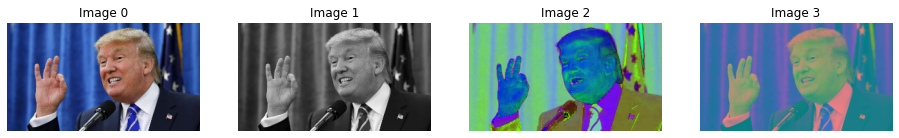

In [10]:
FileName = 'Emotion.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_orig = ResizeImage(image_orig, 300, 0)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([img, image_gray, image_hsv, image_ycbcr], 1, 5)

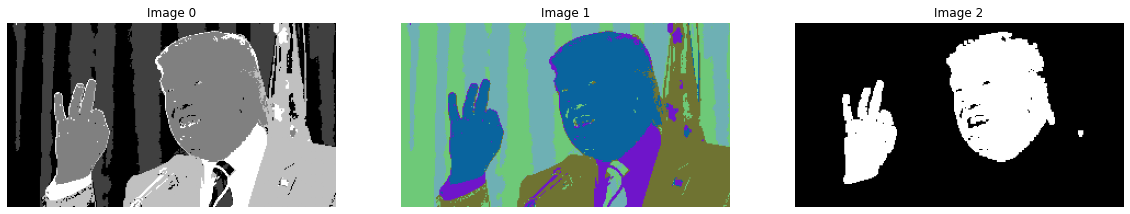

In [11]:
center, result_label, result_image = KmeansSegmentation(image_hsv, 5)
result_label = ReArrangeIndex(result_label)

HSV_mask = cv2.inRange(result_image, (0, 0, 150), (15,170,255)) 
HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

ShowImage([result_label, result_image, HSV_mask], 1, 3)

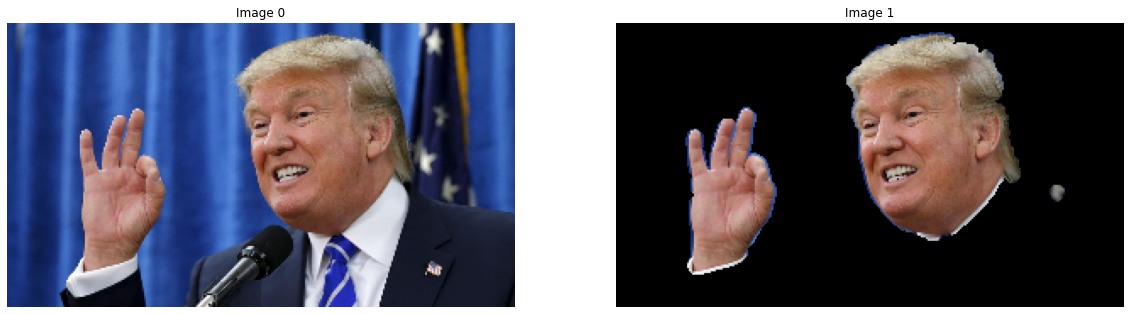

In [12]:
Segment_morpho = morphology(HSV_mask, 2)
final_segment = SegmentColorImageByMask(img, Segment_morpho)
ShowImage([img, final_segment], 1, 2)

**Fuzzy C Means Clustering**

In [13]:
pip install -U scikit-fuzzy

Requirement already up-to-date: scikit-fuzzy in /usr/local/lib/python3.7/dist-packages (0.4.2)


In [14]:
import skfuzzy as fuzz

def change_color_fuzzycmeans(cluster_membership, clusters):
    img = []
    for pix in cluster_membership.T:
        img.append(clusters[np.argmax(pix)])
    return img

def Fuzzy_CMeans_Segmentation(image, cluster):
  shape = np.shape(image)
  if len(image.shape) == 2:
    rgb_img = image_orig.reshape((image.shape[0] * image.shape[1], 1))
  else:
    rgb_img = image_orig.reshape((image.shape[0] * image.shape[1], 3))
  
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(rgb_img.T, cluster, 2, error=0.005, maxiter=1000, init=None, seed=42)
  new_img = change_color_fuzzycmeans(u, cntr)
  fuzzy_img = np.reshape(new_img,shape).astype(np.uint8)
  result_label = fuzzy_img[:,:,1]
  return result_label, fuzzy_img

Selected Image :  
Index  14 
Name  Bone.jpg


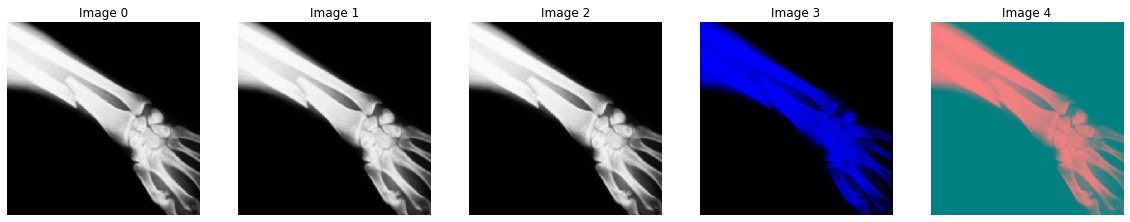

In [15]:
FileName = 'Bone.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
# image_orig = adjust_gamma(image_orig, gamma=0.7)
image_orig = ResizeImage(image_orig, 200, 200)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, img, image_gray, image_hsv, image_ycbcr], 1, 5)

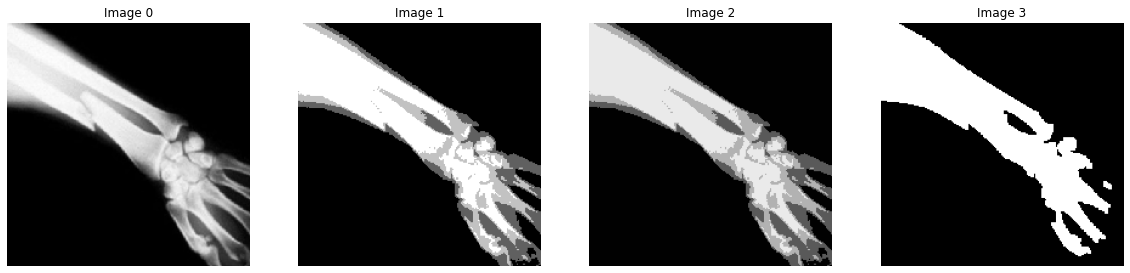

In [16]:
result_label, result_image = Fuzzy_CMeans_Segmentation(image_hsv, 4)

HSV_mask = cv2.inRange(result_image, (100, 100, 100), (240,240,240)) 
HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

ShowImage([img, result_label, result_image, HSV_mask], 1, 4)

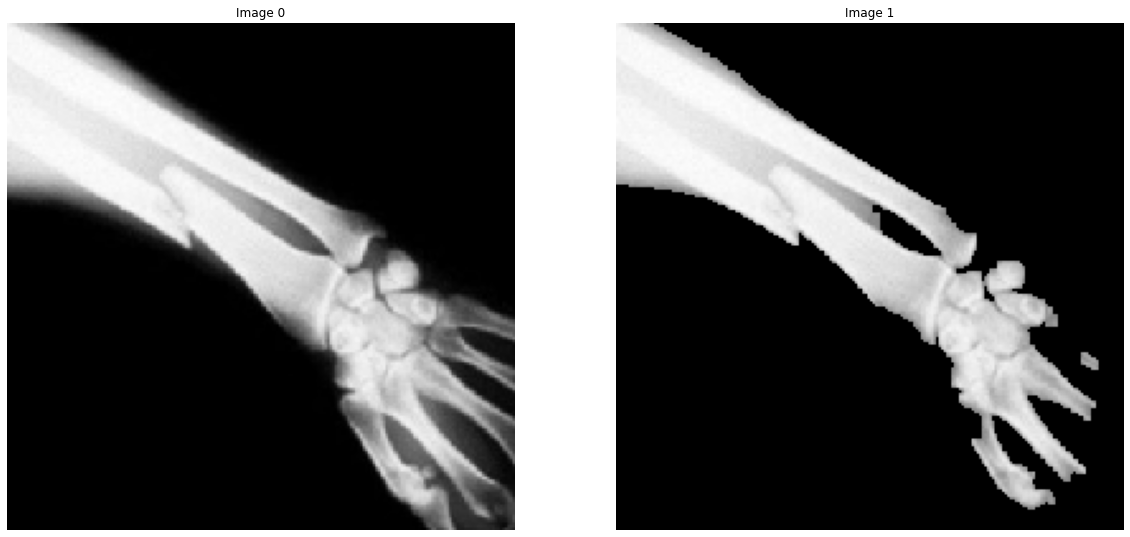

In [17]:
final_segment = SegmentColorImageByMask(img, HSV_mask)
ShowImage([img, final_segment], 1, 2)

**Meanshift**

In [18]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs
from itertools import cycle
from PIL import Image

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [19]:
def MeanShift_Segmentation(image, quantile, n_samples):
  img = np.array(image)
  original_shape = img.shape
  # Flatten image.
  if len(image.shape)==2:
    X = np.reshape(img, [-1, 1])
  else:
    X = np.reshape(img, [-1, image.shape[2]])

  bandwidth = estimate_bandwidth(X, quantile=quantile, n_samples=n_samples)
  ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
  ms.fit(X)
  
  labels = ms.labels_
  cluster_centers = ms.cluster_centers_

  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)

  segmented_image = np.reshape(labels, original_shape[:2])  # Just take size, ignore RGB channels.
  return n_clusters_, segmented_image

Selected Image :  
Index  25 
Name  Cloths.jpg


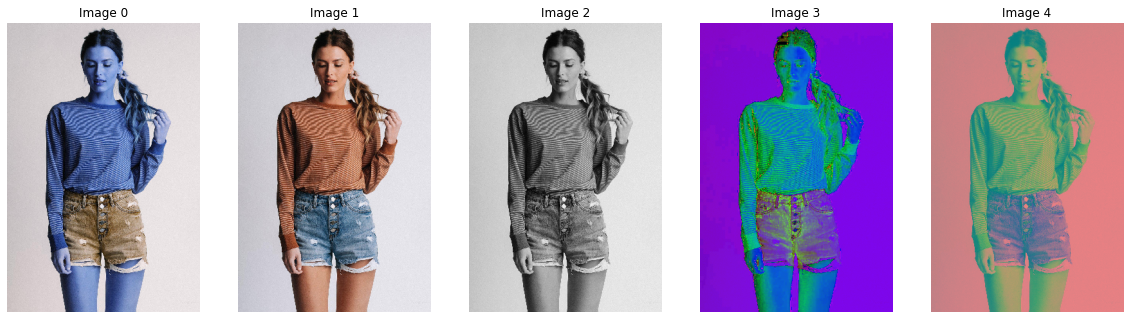

(450, 300, 3)


In [20]:
FileName = 'Cloths.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
# image_orig = adjust_gamma(image_orig, gamma=0.8)
image_orig = ResizeImage(image_orig, 300, 0)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, img, image_gray, image_hsv, image_ycbcr], 1, 5)
print(image_orig.shape)

Number of clusters:  5


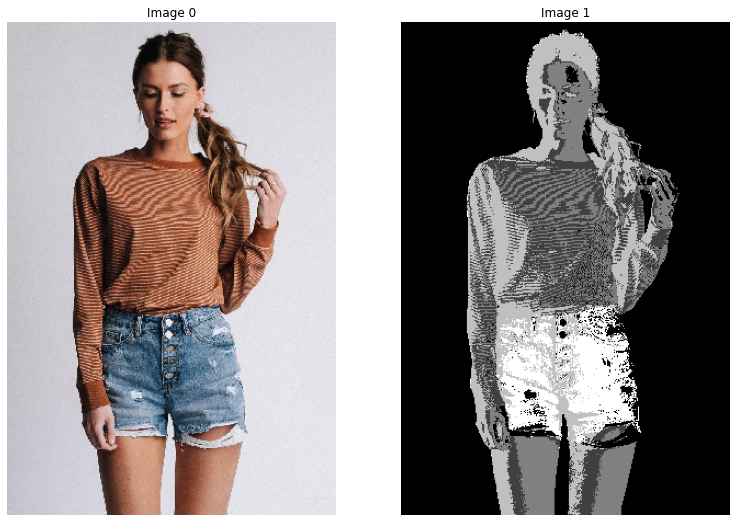

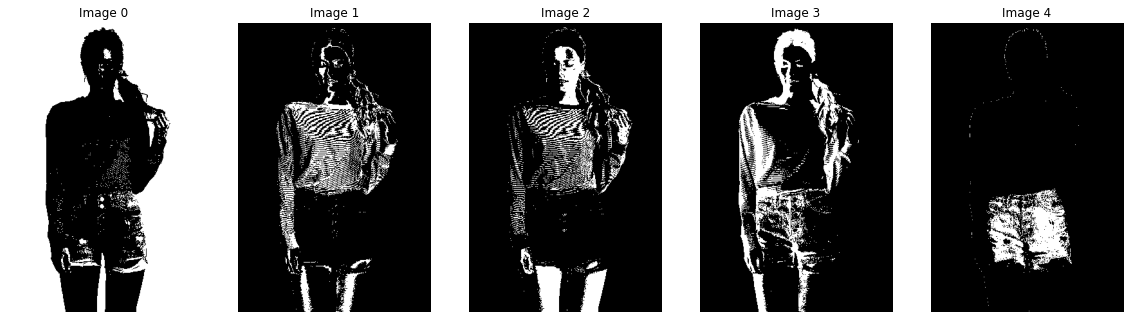

In [21]:
n_clusters, segmented_image = MeanShift_Segmentation(image_ycbcr, quantile=0.2, n_samples=200)
print("Number of clusters: ", n_clusters)
ShowImage([img, segmented_image], 1, 3)
ShowImage([segmented_image == 0, segmented_image == 1, segmented_image == 2, segmented_image == 3, segmented_image == 4], 1, 5)

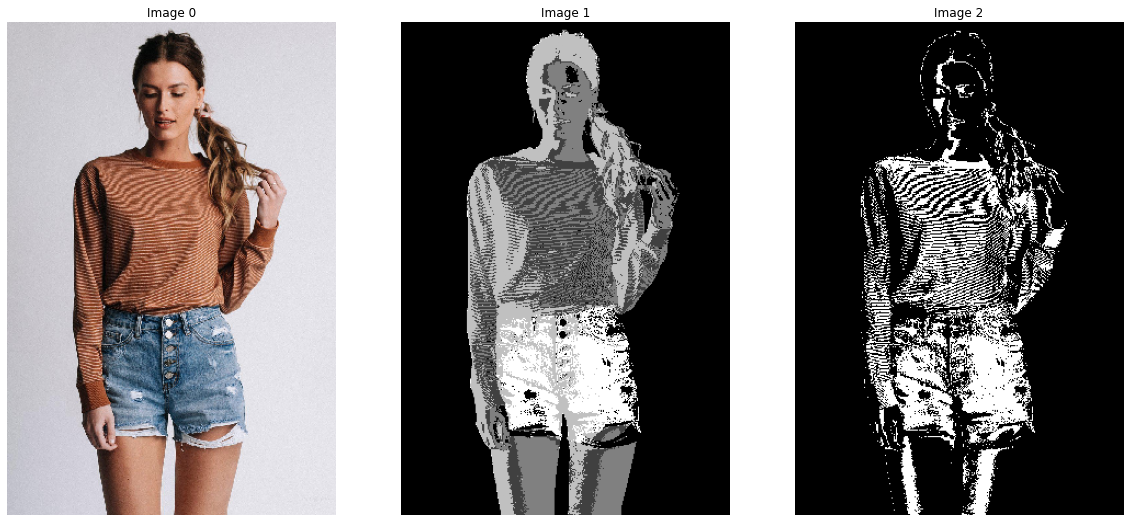

In [22]:
Mask = (segmented_image == 1) + (segmented_image == 4)
ShowImage([img, segmented_image, Mask], 1, 3)

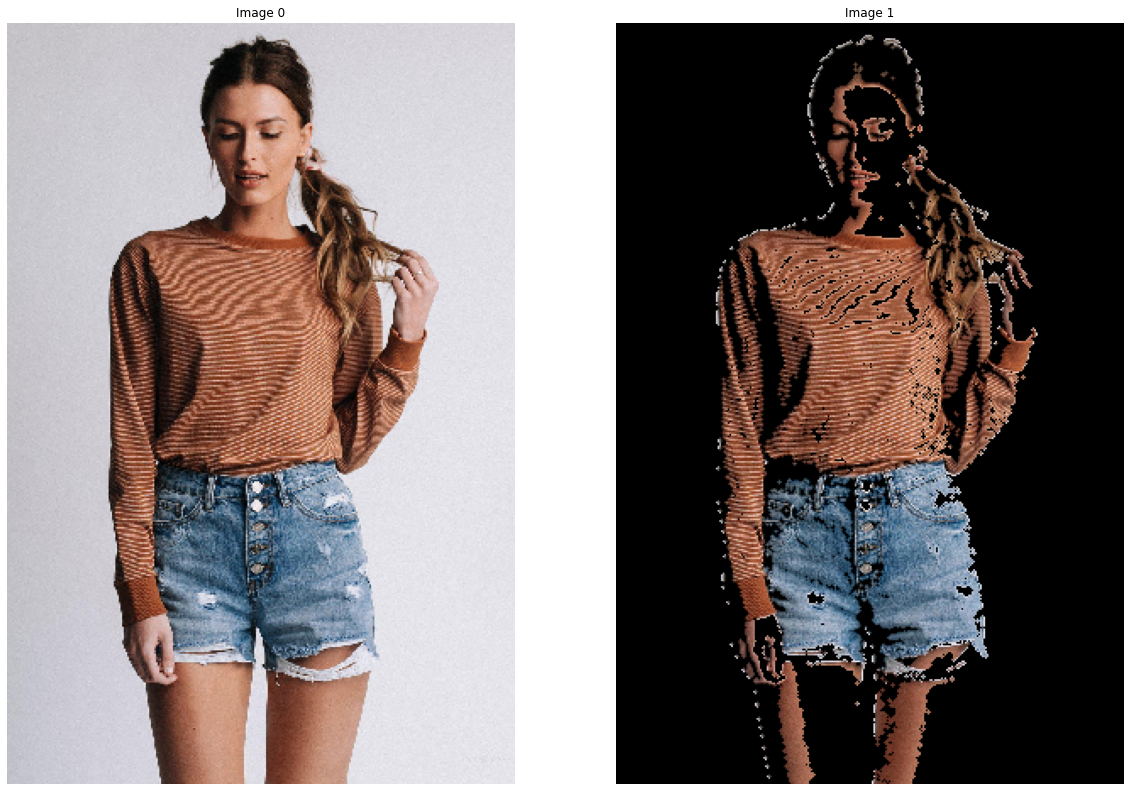

In [23]:
Segment_morpho = morphology(Mask, 1)
final_segment = SegmentColorImageByMask(img, Segment_morpho)
ShowImage([img, final_segment], 1, 2)

**Hierarchy Clustering**

In [24]:
from scipy.ndimage.filters import gaussian_filter
import skimage
from skimage.data import coins
from skimage.transform import rescale
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering

In [25]:
def Hierarchy_Segmentation(image, n_clusters):
  import time as time
  smoothened_img = image.copy()
  if len(image.shape) == 2:
    X = np.reshape(smoothened_img, (-1, 1))
  else:
    X = np.reshape(smoothened_img, (-1, image.shape[2]))
  # Define the structure A of the data. Pixels connected to their neighbors.
  connectivity = grid_to_graph(*smoothened_img.shape[:2])
  # Compute clustering
  print("Compute structured hierarchical clustering...")
  st = time.time()
  ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=connectivity)
  ward.fit(X)
  result_label = np.reshape(ward.labels_, smoothened_img.shape[:2])
  print("Elapsed time: ", time.time() - st)
  print("Number of pixels: ", result_label.size)
  print("Number of clusters: ", np.unique(result_label).size)
  return result_label

Selected Image :  
Index  24 
Name  Leaf.jpg


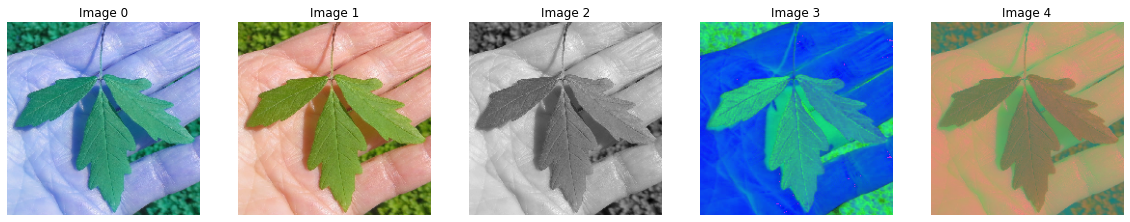

In [26]:
FileName = 'Leaf.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

resize_w = 200
resize_h = 200

image_orig = ImageDB[idx]
image_orig = ResizeImage(image_orig, resize_w, resize_h)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, img, image_gray, image_hsv, image_ycbcr], 1, 5)

In [27]:
n_clusters = 15
result_label = Hierarchy_Segmentation(image_ycbcr, n_clusters=n_clusters)

Compute structured hierarchical clustering...
Elapsed time:  3.9048445224761963
Number of pixels:  40000
Number of clusters:  15


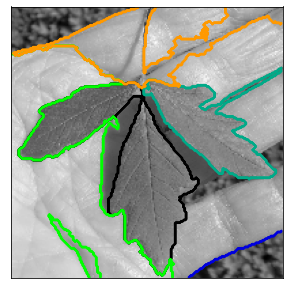

In [28]:
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(image_gray, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(result_label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

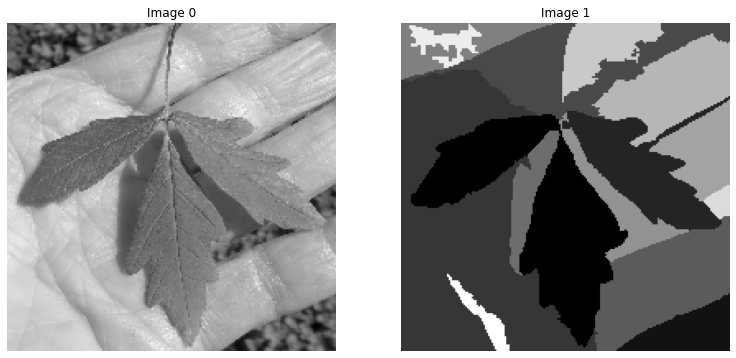

In [29]:
ShowImage([image_gray, result_label], 1, 3)

Index at (80,120) : 2
Index at (100,100) : 0


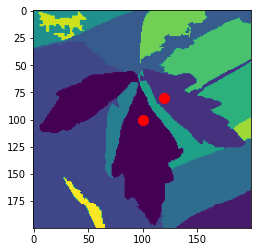

In [30]:
points = [[80, 120], [100, 100]]
SegMask = []
for point in points:
  idx = result_label[point[0], point[1]]
  print("Index at ({0},{1}) : {2}".format(point[0], point[1], idx))
  plt.plot(point[1], point[0], "or", markersize=10)
  SegMask.append(result_label == idx)

plt.imshow(result_label)
plt.show()

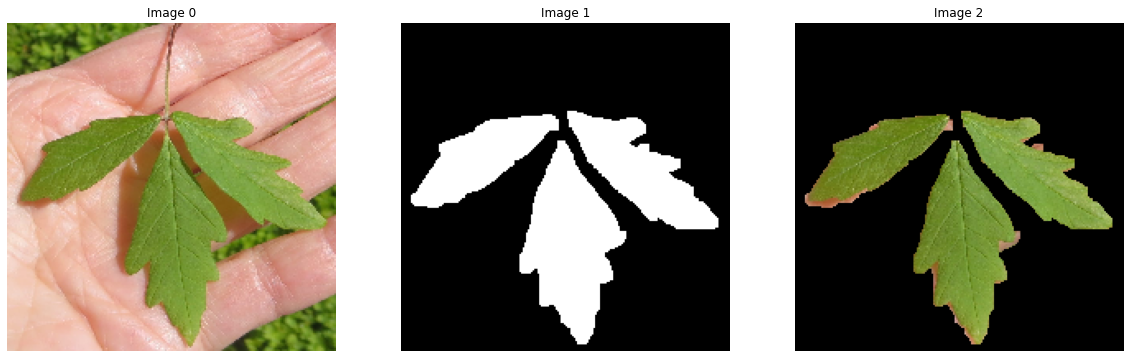

In [31]:
result_segment = sum(SegMask)

kernel = np.ones((5, 5),np.uint8)
result_segment = cv2.morphologyEx(np.float32(result_segment), cv2.MORPH_OPEN, kernel)

final_segment = SegmentColorImageByMask(img, result_segment)
ShowImage([img, result_segment, final_segment], 1, 3)

### Yêu cầu 2.
**Chọn thêm 3 ví dụ trong danh sách hình và định nghĩa object cần segment trong các hình là gì và thực hiện segmentation tốt nhất bằng kmeans, meanshift, fuzzy cmeans, và hierachy clustering.**

**Ví dụ 1: Segment Mask**

Selected Image :  
Index  6 
Name  Mask.jpg


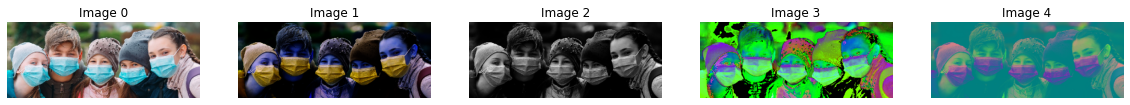

In [130]:
FileName = 'Mask.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

resize_w = 400
resize_h = 0

image_orig = ImageDB[idx]
image_orig = ResizeImage(image_orig, resize_w, resize_h)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image = adjust_gamma(image_orig, gamma=0.3)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
ShowImage([img, image, image_gray, image_hsv, image_ycbcr], 1, 5)

Number of clusters:  7


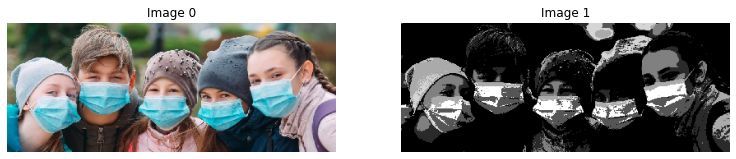

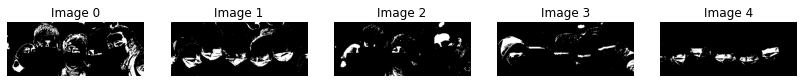

In [131]:
n_clusters, segmented_image = MeanShift_Segmentation(image_ycbcr, quantile=0.1, n_samples=200)
print("Number of clusters: ", n_clusters)
ShowImage([img, segmented_image], 1, 3)
ShowImage([segmented_image == 1, segmented_image == 2, segmented_image == 3, segmented_image == 4, segmented_image == 6], 1, 7)

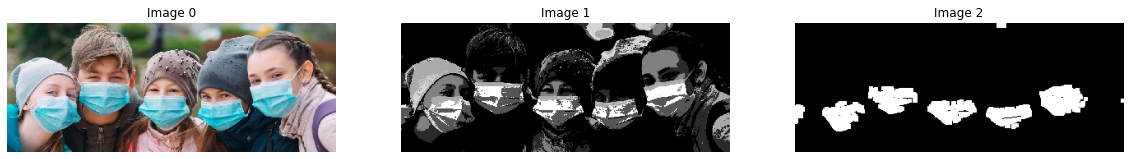

In [134]:
Mask = (segmented_image == 2) + (segmented_image == 6) 
kernel = np.ones((5, 5),np.uint8)
result_segment = cv2.morphologyEx(np.float32(Mask), cv2.MORPH_OPEN, kernel)

ShowImage([img, segmented_image, result_segment], 1, 3)

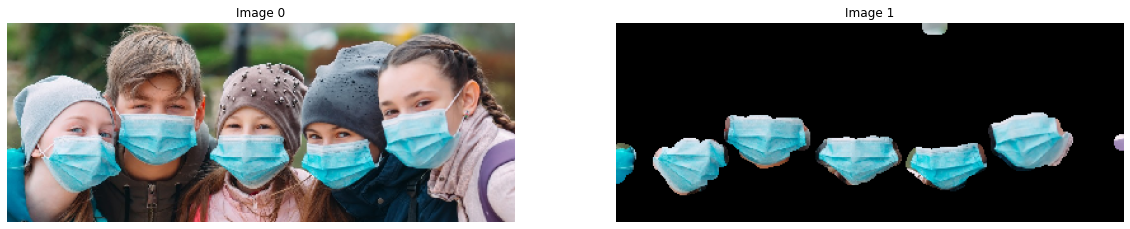

In [138]:
Segment_morpho = morphology(result_segment, 4)
final_segment = SegmentColorImageByMask(img, Segment_morpho)
ShowImage([img, final_segment], 1, 2)

**Ví dụ 2: Segment Mask**

Selected Image :  
Index  15 
Name  Gesture.jpg


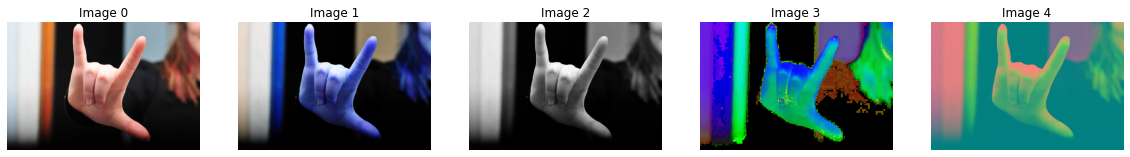

In [141]:
FileName = 'Gesture.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

resize_w = 400
resize_h = 0

image_orig = ImageDB[idx]
image_orig = ResizeImage(image_orig, resize_w, resize_h)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image = adjust_gamma(image_orig, gamma=0.6)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
ShowImage([img, image, image_gray, image_hsv, image_ycbcr], 1, 5)

In [142]:
n_clusters = 15
result_label = Hierarchy_Segmentation(image_ycbcr, n_clusters=n_clusters)

Compute structured hierarchical clustering...
Elapsed time:  9.700162410736084
Number of pixels:  106000
Number of clusters:  15


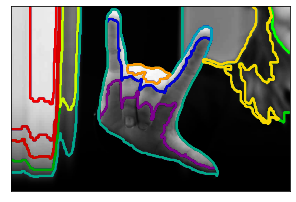

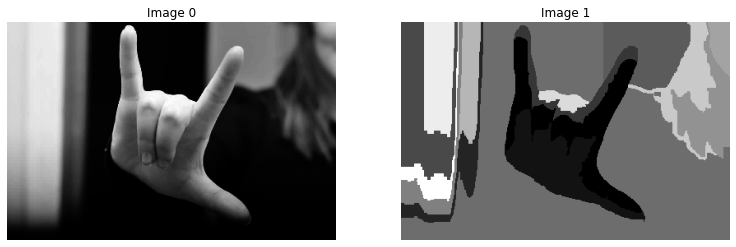

In [148]:
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(image_gray, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(result_label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

ShowImage([image_gray, result_label], 1, 3)

Index at (80,160) : 3
Index at (80,150) : 0
Index at (150,150) : 1
Index at (100,210) : 12


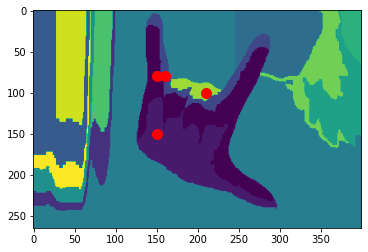

In [156]:
points = [[80, 160], [80, 150], [150, 150], [100, 210]]
SegMask = []
for point in points:
  idx = result_label[point[0], point[1]]
  print("Index at ({0},{1}) : {2}".format(point[0], point[1], idx))
  plt.plot(point[1], point[0], "or", markersize=10)
  SegMask.append(result_label == idx)

plt.imshow(result_label)
plt.show()

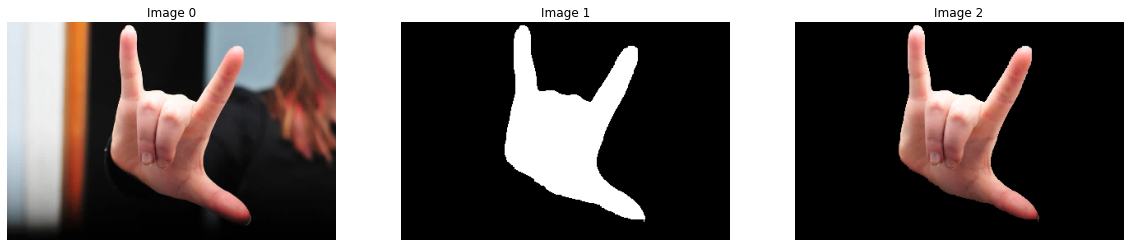

In [157]:
result_segment = sum(SegMask)

final_segment = SegmentColorImageByMask(img, result_segment)
ShowImage([img, result_segment, final_segment], 1, 3)

**Ví dụ 3: Segment Fire**

Selected Image :  
Index  5 
Name  Fire.jpg


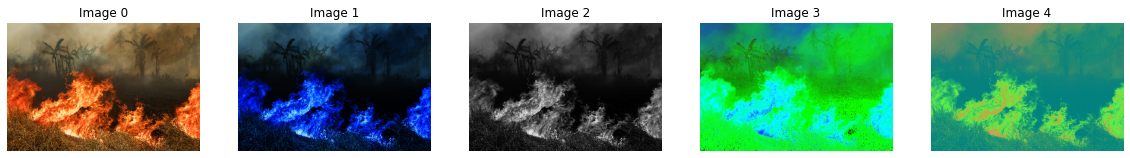

In [231]:
FileName = 'Fire.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

resize_w = 400
resize_h = 0

image_orig = ImageDB[idx]
image_orig = ResizeImage(image_orig, resize_w, resize_h)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image = adjust_gamma(image_orig, gamma=0.5)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
ShowImage([img, image, image_gray, image_hsv, image_ycbcr], 1, 5)

In [251]:
n_clusters = 15
result_label = Hierarchy_Segmentation(image_ycbcr, n_clusters=n_clusters)

Compute structured hierarchical clustering...
Elapsed time:  14.844302415847778
Number of pixels:  106400
Number of clusters:  15


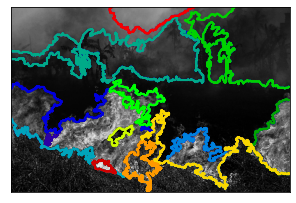

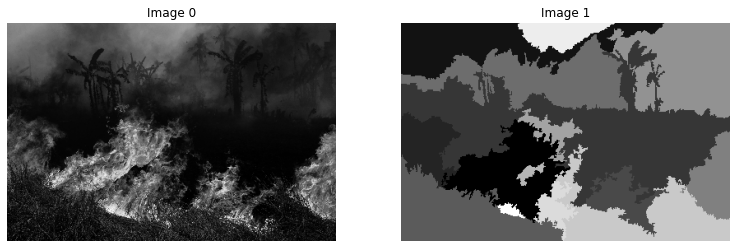

In [252]:
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(image_gray, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(result_label == l,
                colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

ShowImage([image_gray, result_label], 1, 3)

Index at (150,25) : 2
Index at (175,100) : 0
Index at (210,250) : 4
Index at (200,380) : 7
Index at (230,180) : 12
Index at (130,180) : 9


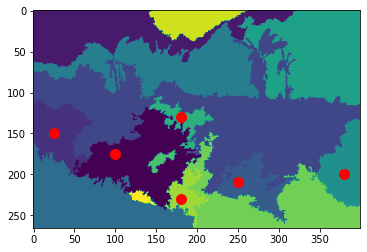

In [254]:
points = [[150, 25], [175, 100], [210, 250], [200, 380], [230, 180], [130, 180]]
SegMask = []
for point in points:
  idx = result_label[point[0], point[1]]
  print("Index at ({0},{1}) : {2}".format(point[0], point[1], idx))
  plt.plot(point[1], point[0], "or", markersize=10)
  SegMask.append(result_label == idx)

plt.imshow(result_label)
plt.show()

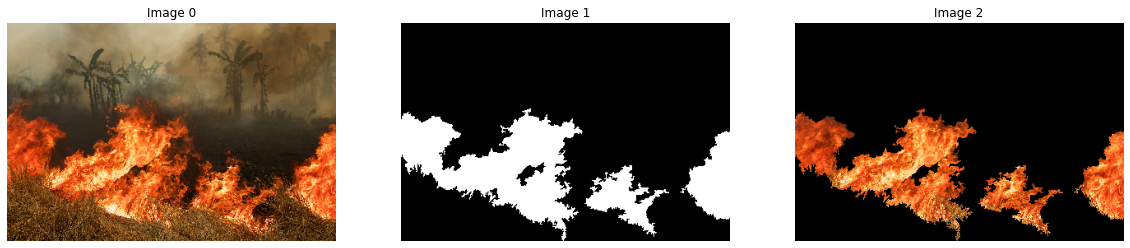

In [255]:
result_segment = sum(SegMask)

final_segment = SegmentColorImageByMask(img, result_segment)
ShowImage([img, result_segment, final_segment], 1, 3)